In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys 
sys.path.insert(0, '../src/')
import mcmc_aux
import SHMR

import warnings; warnings.simplefilter('ignore')

selecting a mock survey from the 105 SAGA data sets

In [3]:
select = np.random.randint(0,105)
print("creating data from SAGA ID:", select)

creating data from SAGA ID: 3


selecting a paramtrization of the SHMR and reading in the data

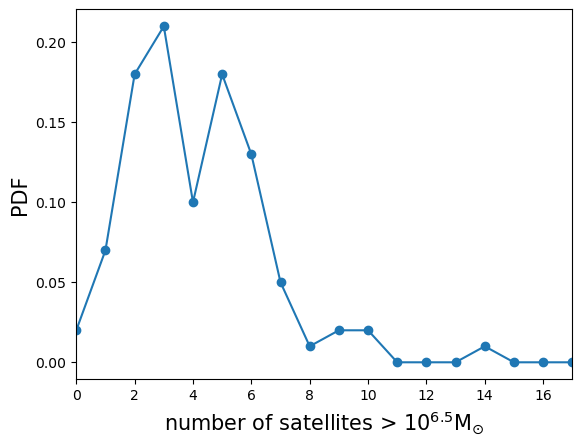

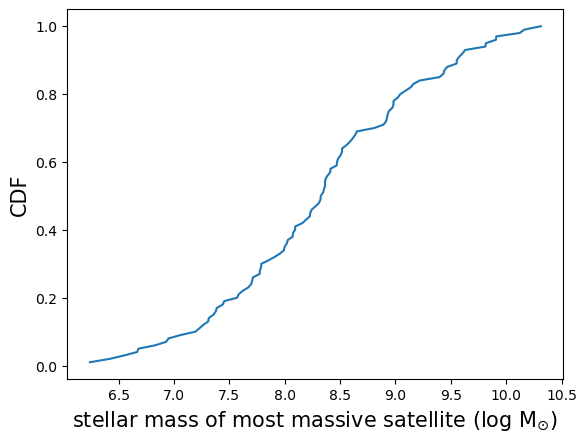

In [4]:
fid_theta = [1.95, -0.3, 0.4]
priors = [[-5, 5],[-3, 1],[0, 5]]
params = ["a_1", "a_2", "a_3"]


data = mcmc_aux.mock_data(fid_theta, SHMR=SHMR.sigma, SAGA_ind=select, mfile="../../data/MCMC/SAGA_samples.npy")
data.get_stats(min_mass=6.5)

defining the foward model(s). They don't include the SAGA index selected as "data"

In [5]:
def forward(theta):
    models = mcmc_aux.models(theta, SHMR.sigma, data.lgMh_models)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

defining the log likelyhood

In [6]:
def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = mcmc_aux.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = mcmc_aux.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and priors[1][0] < theta[1] < priors[1][1] and priors[2][0] < theta[2] < priors[2][1]:
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

intializing the run!

In [7]:
nwalk = 500
nsteps = 100
ndim = len(fid_theta)
start_theta = [1.4, -0.3, 1] # a somewhat random starting place

RUNNING!

In [8]:
mcmc_out = mcmc_aux.RUN(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim)

Run took 848.7 seconds


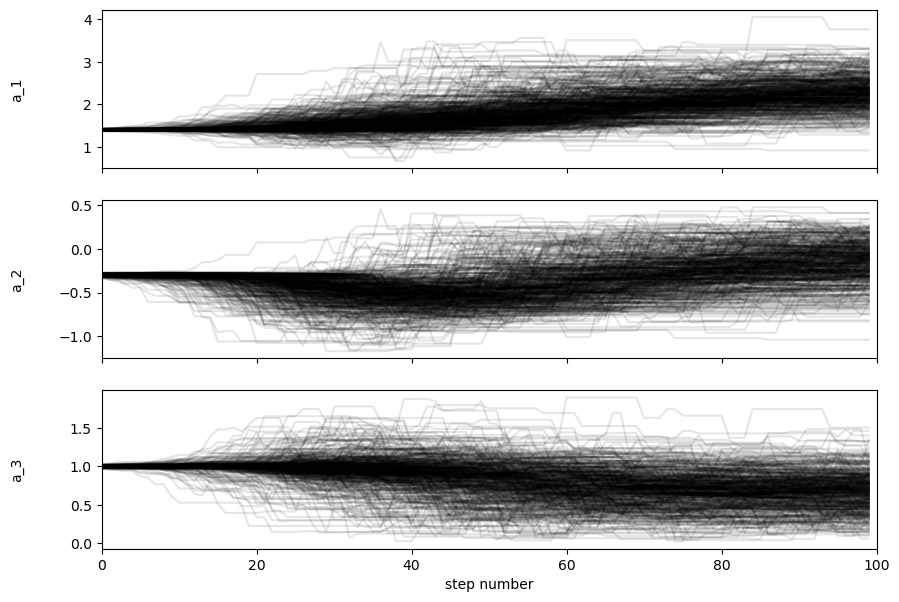

In [9]:
run = mcmc_aux.inspect_run(mcmc_out, fid_theta=data.fid_theta, labels=params, priors=priors)
run.chain_plot()

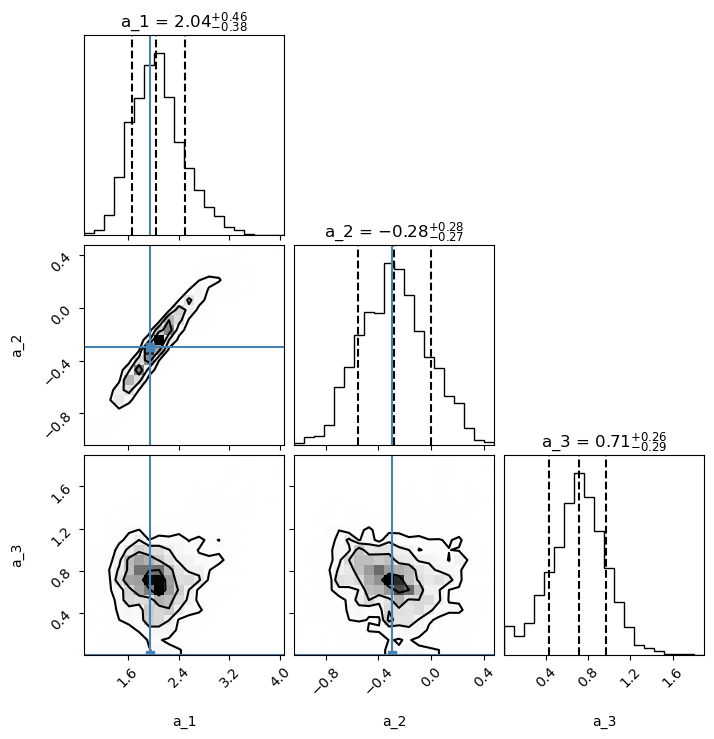

In [13]:
run.corner_plot(burn=50, zoom=True)

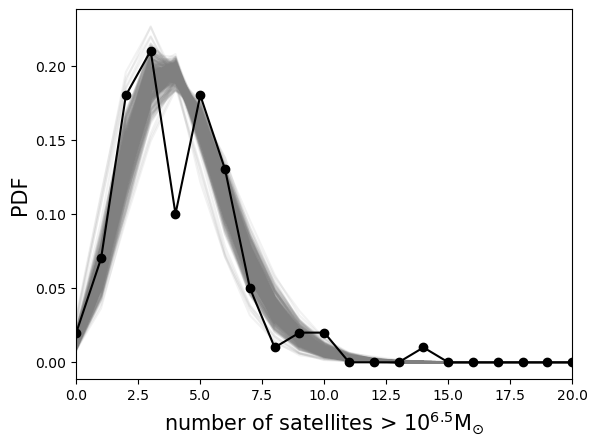

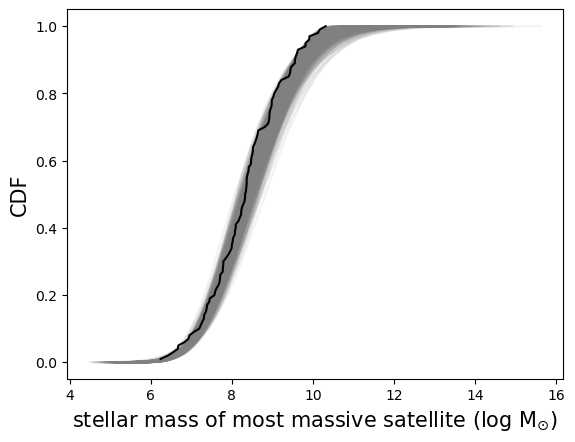

In [11]:
run.stat_plot(data, forward)

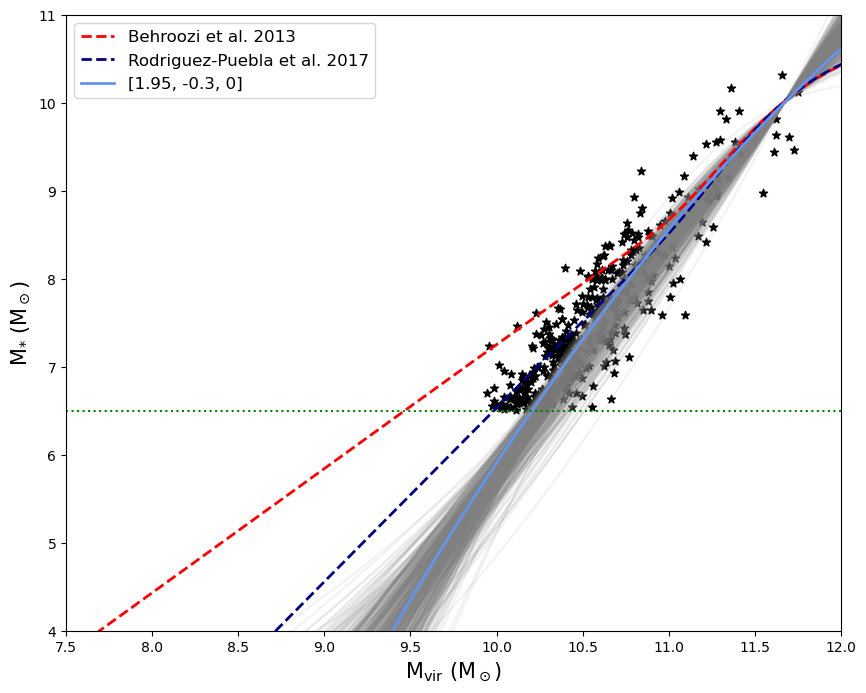

In [12]:
run.SHMR_plot(data, SHMR.sigma)